In [1]:
# Ajustar path para poder importar módulos desde src/
import sys
import os

# Obtener el path de la carpeta raíz del proyecto
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Añadir la carpeta raíz al sys.path
if root_path not in sys.path:
    sys.path.append(root_path)


Cargando y preprocesando datos...
Distribución de sentimientos:
   Sentimiento  Cantidad  Proporción (%)
0            0     29720           92.99
1            1      2242            7.01


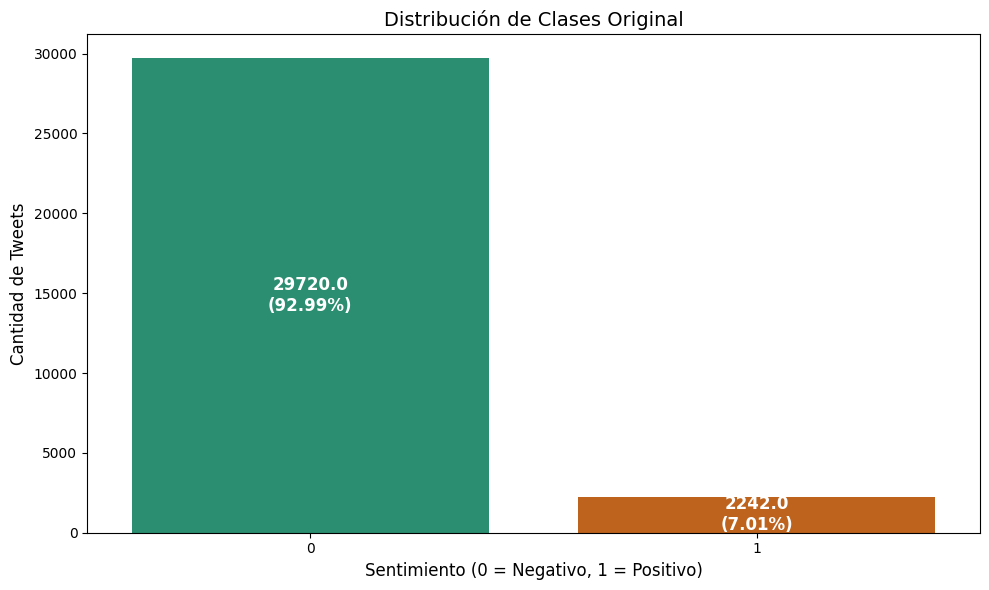

Distribución de sentimientos:
   Sentimiento  Cantidad  Proporción (%)
0            0     29720            50.0
1            1     29720            50.0


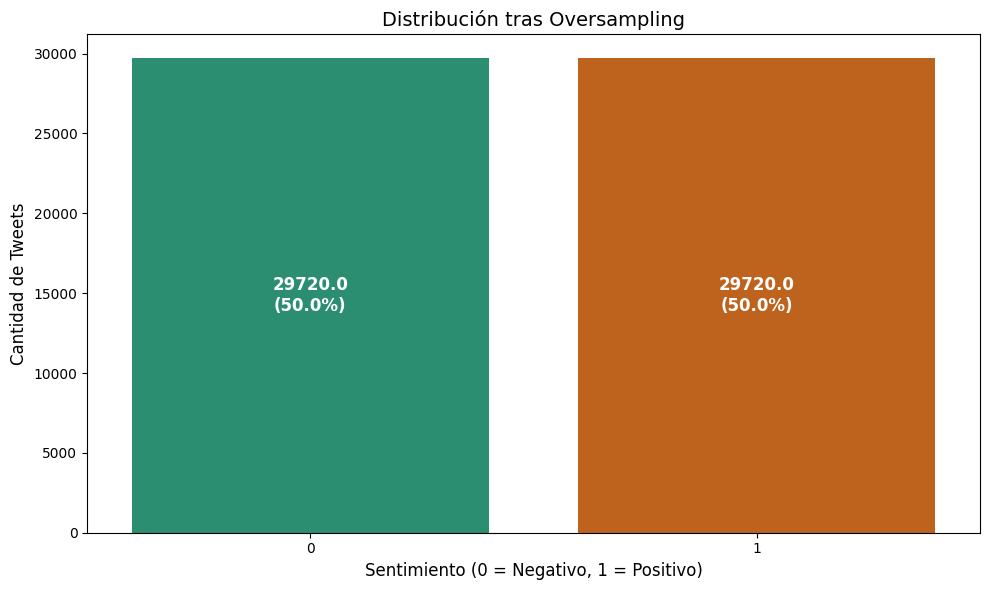

In [2]:
# 1. Importar librerías necesarias
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from src.data_loader import load_data, prepare_data, get_class_weights
from src.model_bilstm_attention import create_bilstm_attention_model
from src.utils import plot_history, evaluate_model, plot_class_distribution

# 2. Cargar y preparar los datos
print("Cargando y preprocesando datos...")
df = load_data()

# Visualizar distribución de clases
plot_class_distribution(df, title="Distribución de Clases Original")

# Preparar datos para entrenamiento
test_size = 0.2  # 80% entrenamiento, 20% prueba
max_words = 10000
max_len = 100
X_train, X_test, y_train, y_test, tokenizer = prepare_data(df, max_words=max_words, max_len=max_len, test_size=test_size)


# 2. Carga datos y aplica oversampling en la fase de lectura
from src.data_loader import load_data, prepare_data
from src.utils import plot_class_distribution

# Carga y preprocesa, duplicando la clase minoritaria (label invertido a 1=positivo)
df = load_data(balance_method='oversampling')
plot_class_distribution(df, title="Distribución tras Oversampling")

# 3. Preparar datos SIN SMOTE (ya balanceamos arriba)
X_train, X_test, y_train, y_test, tokenizer = prepare_data(
    df,
    max_words=max_words,
    max_len=max_len,
    test_size=test_size,
    balance_method=None   # ya hicimos oversampling
)


Creando modelo BiLSTM + Atención...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          66048     
 al)                                                             
                                                                 
 attention_layer (Attention  (None, 128)               129       
 Layer)                                                          
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)           

c:\Users\USER\Documentos\Maestria\Deep_Learning\Taller2_DL_AnalisisSentimientos\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


372/372 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9585
Epoch 2: val_loss did not improve from 0.08239
372/372 [==============================] - 221s 594ms/step - loss: 0.1163 - accuracy: 0.9585 - val_loss: 0.1353 - val_accuracy: 0.9647
Epoch 3/5
372/372 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9784
Epoch 3: val_loss improved from 0.08239 to 0.04688, saving model to models\bilstm_attention_model.h5
372/372 [==============================] - 345s 928ms/step - loss: 0.0745 - accuracy: 0.9784 - val_loss: 0.0469 - val_accuracy: 0.9870
Epoch 4/5
372/372 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9922
Epoch 4: val_loss did not improve from 0.04688
372/372 [==============================] - 281s 754ms/step - loss: 0.0327 - accuracy: 0.9922 - val_loss: 0.0666 - val_accuracy: 0.9844
Epoch 5/5
372/372 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9922
Epoch 5: val_loss did not impr

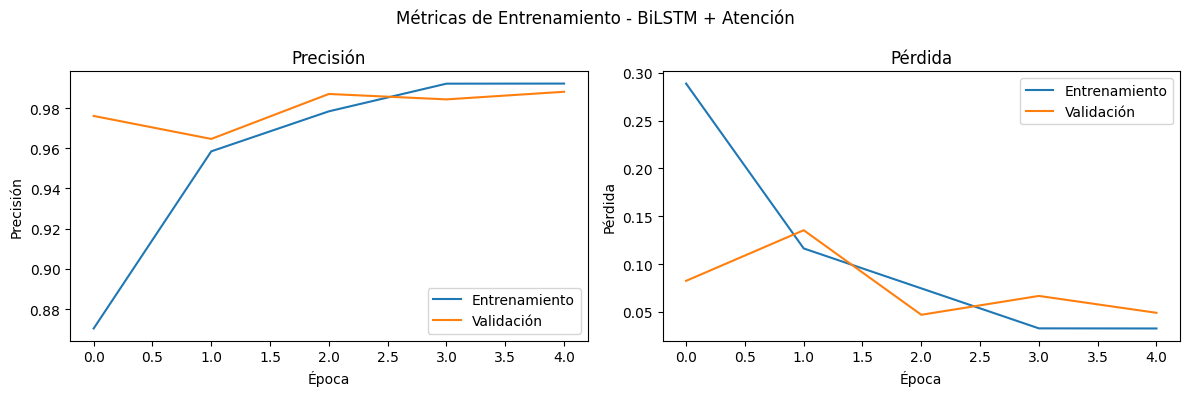


Evaluando desempeño del modelo...
372/372 [==============================] - 9s 22ms/step
Accuracy: 0.9881
Precision: 0.9792
Recall: 0.9975
F1-score: 0.9882


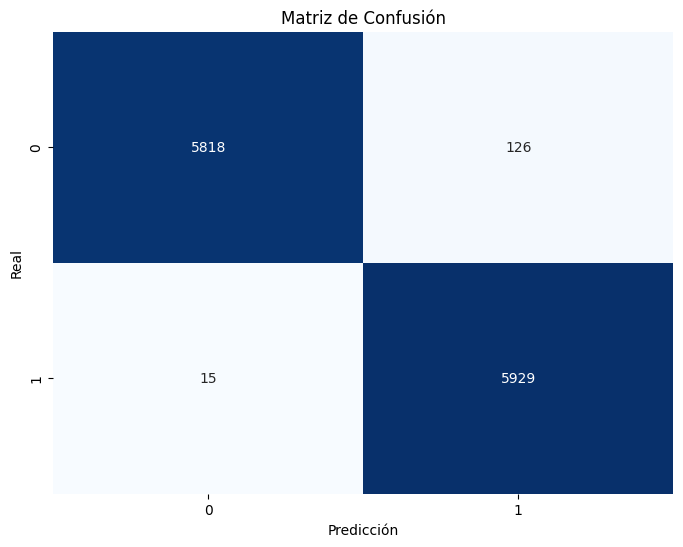

Tokenizer guardado en: models\bilstm_attention_tokenizer.json

Métricas finales:
accuracy: 0.9881
precision: 0.9792
recall: 0.9975
f1: 0.9882


In [3]:
# 3. Definir parámetros del modelo
embedding_dim = 64
lstm_units = 64
dropout_rate = 0.3
batch_size = 128
epochs = 5
validation_split = 0.2
patience = 3
save_dir = 'models'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 4. Crear modelo BiLSTM + Atención
print("Creando modelo BiLSTM + Atención...")
model = create_bilstm_attention_model(vocab_size=max_words, max_len=max_len,
                                      embedding_dim=embedding_dim, 
                                      lstm_units=lstm_units, 
                                      dropout_rate=dropout_rate)

model.summary()

# 5. Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(save_dir, "bilstm_attention_model.h5"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# 6. Entrenar modelo
print("Entrenando modelo...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

# 7. Visualizar métricas de entrenamiento
plot_history(history, title="Métricas de Entrenamiento - BiLSTM + Atención")

# 8. Evaluar modelo
print("\nEvaluando desempeño del modelo...")
metrics = evaluate_model(model, X_test, y_test)

# 9. Guardar tokenizer
tokenizer_json = tokenizer.to_json()
tokenizer_path = os.path.join(save_dir, "bilstm_attention_tokenizer.json")
with open(tokenizer_path, 'w') as f:
    f.write(tokenizer_json)

print(f"Tokenizer guardado en: {tokenizer_path}")

# 10. Mostrar métricas finales
print("\nMétricas finales:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")